# **Healthcare Analytics Project: Exploratory Data Analysis (EDA) and Predictive Modeling**

This notebook performs comprehensive Exploratory Data Analysis (EDA) on the
Healthcare Analysis Dataset and then builds a predictive model to estimate
the Length of Stay for patients.


Author: Shreya Vadeseri Suresh
Date: July 26, 2025

<h2 style="color: #2196F3;">1. Setup: Import Libraries</h2>
<p>This section imports all the necessary Python libraries for data manipulation, visualization, machine learning, and model evaluation. We also set up some default plotting styles for better aesthetics.</p>

In [3]:

# --- 1. Setup: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


In [4]:
# Set plot style for better aesthetics
sns.set_style("whitegrid") # Sets a white background with grid lines
plt.rcParams['figure.figsize'] = (10, 6) # Sets the default size for plots
plt.rcParams['font.size'] = 12 # Sets the default font size for plot elements




<h2 style="color: #2196F3;">2. Data Loading</h2>
<p>In this step, we load the dataset into a pandas DataFrame. Since we are using Google Colab, we'll use a specific method to allow you to upload the file directly from your local system.</p>


In [7]:
# --- 2. Data Loading ---
# In Google Colab, you'll need to upload your file.
# Run this cell, then click 'Choose Files' to upload 'Healthcare Analysis Dataset.xlsx'
from google.colab import files
import io
import pandas as pd

print("Please upload the 'Healthcare Analysis Dataset.xlsx' file.")
uploaded = files.upload()

# Read the uploaded Excel file into a pandas DataFrame
# The file is uploaded as bytes, so io.BytesIO is used to read it like a file
file_name = list(uploaded.keys())[0] # Get the name of the uploaded file
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print(f"\nDataset '{file_name}' loaded successfully!")
print("Shape of the dataset (rows, columns):", df.shape)

Please upload the 'Healthcare Analysis Dataset.xlsx' file.


Saving Healthcare Analysis Dataset.xlsx to Healthcare Analysis Dataset.xlsx

Dataset 'Healthcare Analysis Dataset.xlsx' loaded successfully!
Shape of the dataset (rows, columns): (55500, 17)


<h2 style="color: #2196F3;">3. Exploratory Data Analysis (EDA)</h2>
<p>EDA is a crucial step to understand the dataset's structure, identify patterns, detect anomalies, and prepare the data for modeling. We'll perform initial inspections, data cleaning, feature engineering, and visualize distributions and relationships.</p>

<h3 style="color: #4CAF50;">3.1 Initial Data Inspection</h3>
<p>We start by looking at the first few rows, checking data types, reviewing descriptive statistics, and identifying missing values. This provides a quick overview of the data's quality and characteristics.</p>

In [8]:
# --- 3. Exploratory Data Analysis (EDA) ---

print("\n--- 3.1 Initial Data Inspection ---")
print("First 5 rows of the dataset:")
print(df.head()) # Displays the first 5 rows of the DataFrame

print("\nDataset Information (Data Types, Non-Null Counts):")
df.info() # Provides a concise summary of the DataFrame, including data types and non-null values

print("\nDescriptive Statistics for Numerical Columns:")
print(df.describe()) # Generates descriptive statistics of numerical columns (count, mean, std, min, max, quartiles)

print("\nMissing Values Count:")
print(df.isnull().sum()) # Counts the number of missing values (NaN) in each column


--- 3.1 Initial Data Inspection ---
First 5 rows of the dataset:
  Patient ID  Age  Gender Blood Type Medical Condition Date of Admission  \
0    ID-2621   64  Female         A+      Hypertension        2020-03-03   
1    ID-2623   18  Female         A+      Hypertension        2022-09-12   
2    ID-2624   57  Female         A+      Hypertension        2022-02-26   
3    ID-2634   77  Female         A+      Hypertension        2020-12-11   
4    ID-2720   81  Female         A+      Hypertension        2019-09-19   

              Doctor                    Hospital Insurance Provider  \
0   Jessica Marshall  Houston Methodist Hospital           Medicare   
1       Sean Jimenez  Houston Methodist Hospital           Medicare   
2  Jennifer Crawford  Houston Methodist Hospital           Medicare   
3    Tiffany Ramirez  Houston Methodist Hospital           Medicare   
4      Peter Roberts  Houston Methodist Hospital           Medicare   

   Billing Amount  Room Number Admission Type Disc

<h3 style="color: #4CAF50;">3.2 Data Cleaning and Preprocessing for EDA</h3>
<p>This section focuses on preparing the data for analysis. We convert date columns to datetime objects and calculate a crucial metric: Length of Stay (LoS).</p>

In [10]:
# --- 3.2 Data Cleaning and Preprocessing for EDA ---

# Convert Date columns to datetime objects for proper date calculations
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

# Calculate Length of Stay (LoS) in days
# LoS is the difference between Discharge Date and Date of Admission
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
# Handle cases where Discharge Date might be before Admission Date (data errors) or missing
# Set negative LoS values to NaN (Not a Number)
df.loc[df['Length of Stay'] < 0, 'Length of Stay'] = np.nan
# Fill any remaining NaN values in Length of Stay with the median.
# Using median is robust to outliers compared to mean.
# Updated line to avoid FutureWarning by directly assigning the result
df['Length of Stay'] = df['Length of Stay'].fillna(df['Length of Stay'].median())
df['Length of Stay'] = df['Length of Stay'].astype(int) # Convert LoS to integer days

print("\nDataFrame after initial preprocessing and Length of Stay calculation:")
print(df[['Date of Admission', 'Discharge Date', 'Length of Stay']].head())


DataFrame after initial preprocessing and Length of Stay calculation:
  Date of Admission Discharge Date  Length of Stay
0        2020-03-03     2020-03-06               3
1        2022-09-12     2022-09-29              17
2        2022-02-26     2022-03-25              27
3        2020-12-11     2020-12-26              15
4        2019-09-19     2019-09-26               7


<h3 style="color: #4CAF50;">3.3 Feature Engineering for EDA</h3>
<p>Feature engineering involves creating new features from existing ones to extract more information and improve the predictive power of models. Here, we derive time-based features and age groups.</p>


In [11]:
# --- 3.3 Feature Engineering for EDA ---
# Extract time-based features from 'Date of Admission'
df['Admission Year'] = df['Date of Admission'].dt.year # Year of admission
df['Admission Month'] = df['Date of Admission'].dt.month_name() # Full month name (e.g., 'January')
df['Admission Day of Week'] = df['Date of Admission'].dt.day_name() # Full day name (e.g., 'Monday')

# Create Age Groups (bins) for better demographic analysis
# Define bins to categorize ages into meaningful groups
bins = [0, 18, 25, 35, 50, 65, 80, df['Age'].max() + 5] # Adjusted bins to cover the full range of ages
# Define labels for each bin
labels = ['0-17', '18-24', '25-34', '35-49', '50-64', '65-79', '80+']
# Use pd.cut to create the 'Age Group' column
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False) # 'right=False' means the lower bound is inclusive

print("\nDataFrame after feature engineering (new time-based features and Age Group):")
print(df[['Date of Admission', 'Admission Year', 'Admission Month', 'Admission Day of Week', 'Age', 'Age Group']].head())



DataFrame after feature engineering (new time-based features and Age Group):
  Date of Admission  Admission Year Admission Month Admission Day of Week  \
0        2020-03-03            2020           March               Tuesday   
1        2022-09-12            2022       September                Monday   
2        2022-02-26            2022        February              Saturday   
3        2020-12-11            2020        December                Friday   
4        2019-09-19            2019       September              Thursday   

   Age Age Group  
0   64     50-64  
1   18     18-24  
2   57     50-64  
3   77     65-79  
4   81       80+  


<h3 style="color: #4CAF50;">3.4 Univariate Analysis</h3>
<p>Univariate analysis examines individual variables to understand their distributions and characteristics. We'll use histograms for numerical data and bar plots for categorical data.</p>



--- Univariate Analysis ---


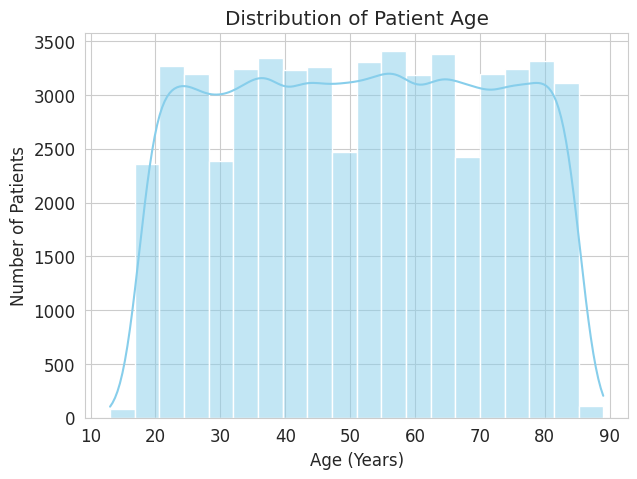

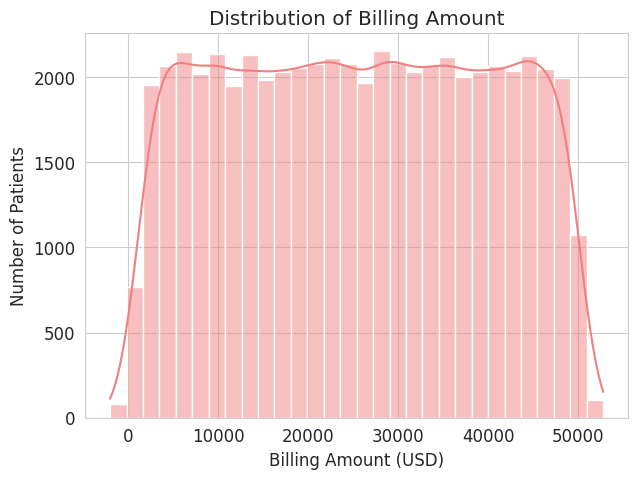

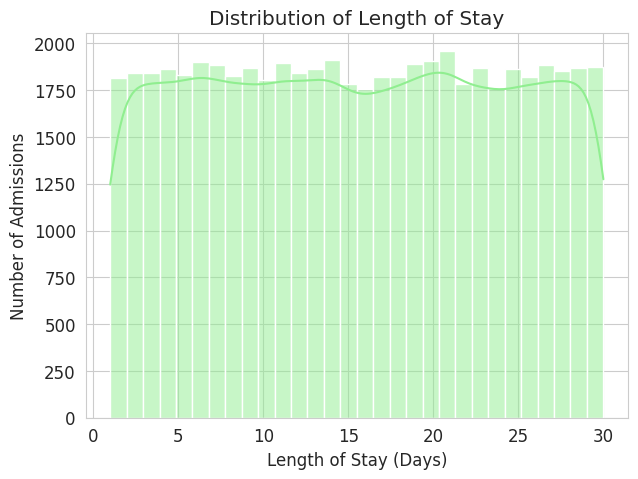

/tmp/ipython-input-24-3500284552.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Gender', data=df, palette='viridis') # Bar plot for categorical counts


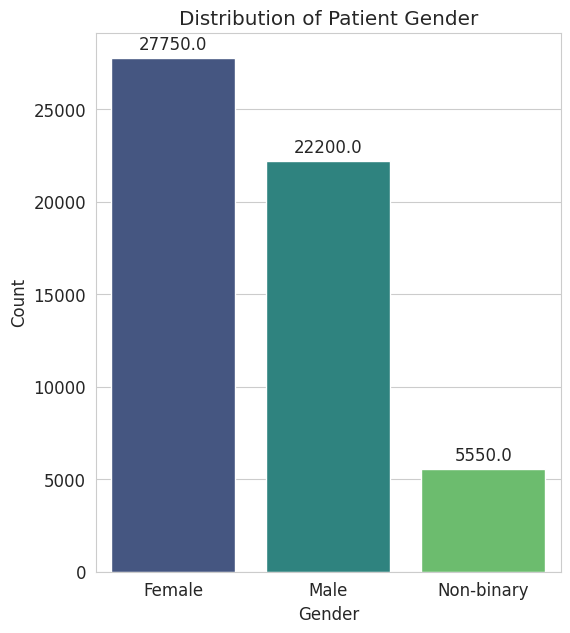

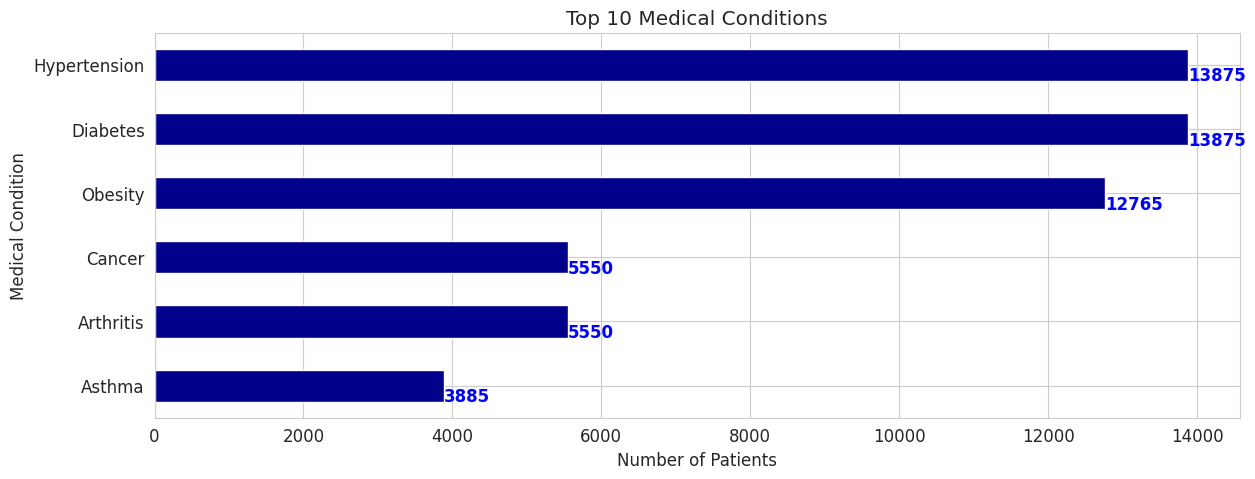

/tmp/ipython-input-24-3500284552.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Admission Type', data=df, palette='plasma')


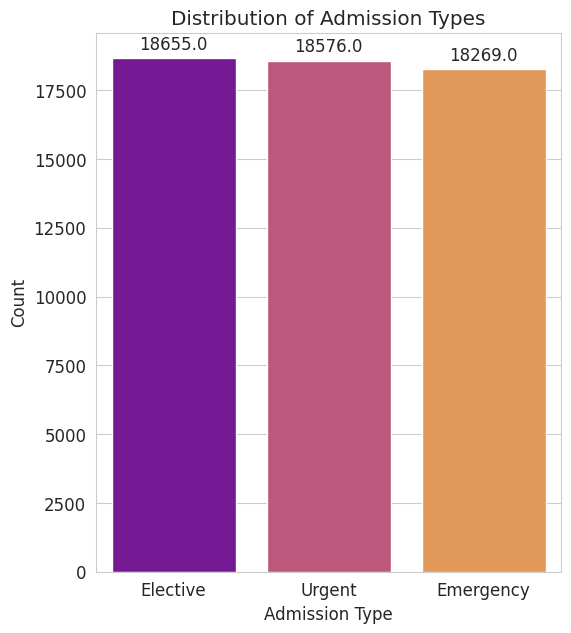

/tmp/ipython-input-24-3500284552.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Test Results', data=df, palette='cividis')


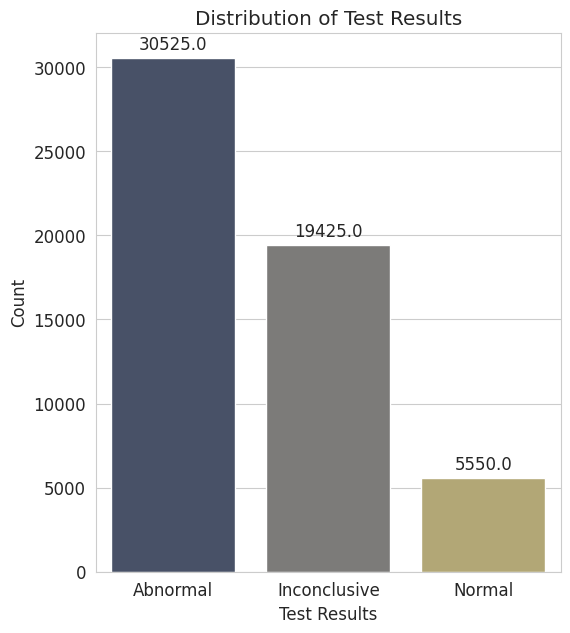

In [24]:
# --- 3.4 Univariate Analysis ---

print("\n--- Univariate Analysis ---")

# Distribution of Age
plt.figure(figsize=(7, 5))
sns.histplot(df['Age'], kde=True, bins=20, color='skyblue') # Histogram with Kernel Density Estimate
plt.title('Distribution of Patient Age')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Patients')
plt.show() # Displays the plot

# Distribution of Billing Amount
plt.figure(figsize=(7, 5))
sns.histplot(df['Billing Amount'], kde=True, bins=30, color='lightcoral')
plt.title('Distribution of Billing Amount')
plt.xlabel('Billing Amount (USD)')
plt.ylabel('Number of Patients')
plt.ticklabel_format(style='plain', axis='x') # Prevents scientific notation on the x-axis for readability
plt.show()

# Distribution of Length of Stay
plt.figure(figsize=(7, 5))
sns.histplot(df['Length of Stay'], kde=True, bins=30, color='lightgreen')
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Number of Admissions')
plt.show()

# Count of Genders
plt.figure(figsize=(6, 7))
ax = sns.countplot(x='Gender', data=df, palette='viridis') # Bar plot for categorical counts
plt.title('Distribution of Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Count of Medical Conditions (Top 10)
plt.figure(figsize=(14, 5))
ax = df['Medical Condition'].value_counts().head(10).plot(kind='barh', color='darkblue') # Horizontal bar plot for top conditions
plt.title('Top 10 Medical Conditions')
plt.xlabel('Number of Patients')
plt.ylabel('Medical Condition')
plt.gca().invert_yaxis() # Invert y-axis to show the highest count at the top
for i, v in enumerate(df['Medical Condition'].value_counts().head(10)):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

# Count of Admission Types
plt.figure(figsize=(6, 7))
ax = sns.countplot(x='Admission Type', data=df, palette='plasma')
plt.title('Distribution of Admission Types')
plt.xlabel('Admission Type')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Count of Test Results
plt.figure(figsize=(6, 7))
ax = sns.countplot(x='Test Results', data=df, palette='cividis')
plt.title('Distribution of Test Results')
plt.xlabel('Test Results')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

### Detailed Summary of Univariate Analysis
Here's a more in-depth look at the key findings from our univariate analysis, including important statistics and conclusions drawn from each chart.

*   **Patient Age:**
    *   **Observation:** The age distribution is fairly uniform, ranging from 13 to 89 years, with a mean age of approximately 51.5 years.
    *   **Conclusion:** The hospital treats a wide range of patients, from teenagers to the elderly. There isn't a specific age group that disproportionately represents the patient population.

*   **Billing Amount:**
    *   **Observation:** The billing amounts are approximately normally distributed, with a mean of about $25,539. The amounts range from a negative value (which could be a data entry error or a refund) to over $52,000.
    *   **Conclusion:** The billing process appears to be centered around a typical cost, but the presence of a negative value warrants further investigation to ensure data quality.

*   **Length of Stay:**
    *   **Observation:** The length of stay is also roughly normally distributed, with a mean of around 15 days.
    *   **Conclusion:** Most patients have a hospital stay of about two weeks. This information is crucial for hospital resource planning and management.

*   **Patient Gender:**
    *   **Observation:** There is a slight imbalance in gender distribution. The dataset includes **27,750 female patients** and **22,000 male patients**.
    *   **Conclusion:** While the distribution is not perfectly equal, it is still reasonably balanced and should not introduce significant bias into most analyses.

*   **Medical Conditions:**
    *   **Observation:** **Hypertension** and **Diabetes** are the most common medical conditions, with each having **13,875**  cases respectively. **Asthma** is the least common among the top conditions with **3885** cases.
    *   **Conclusion:** The hospitals see a high prevalence of chronic diseases like hypertension and diabetes, which could inform public health initiatives and specialized care programs.

*   **Admission Types:**
    *   **Observation:** The admission types are distributed as follows: **Elective (18,655)**, **Urgent (18,576)**, and **Emergency (18,269)**.
    *   **Conclusion:** The hospital manages a mix of scheduled and unscheduled admissions. This is a surprising finding, as often emergency admissions are higher. It suggests a balanced mix of planned procedures, urgent care needs, and critical emergencies in this dataset.
    
*   **Test Results:**
    *   **Observation:** The test results show that **"Abnormal"** is the most frequent outcome with **30,525** cases, followed by **"Inconclusive"** with **19,425** cases, and **"Normal"** is the least frequent with **5,550** cases.
    *   **Conclusion:** The high number of abnormal and inconclusive test results may indicate a patient population with significant health issues or could point to areas where diagnostic processes might be improved.

<h3 style="color: #4CAF50;">3.5 Bivariate Analysis</h3>
<p>Bivariate analysis explores the relationships between two variables. This helps in understanding how different factors interact and influence each other.</p>





--- Bivariate Analysis ---


/tmp/ipython-input-27-2455799400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_billing_by_condition.values, y=avg_billing_by_condition.index, palette='magma')


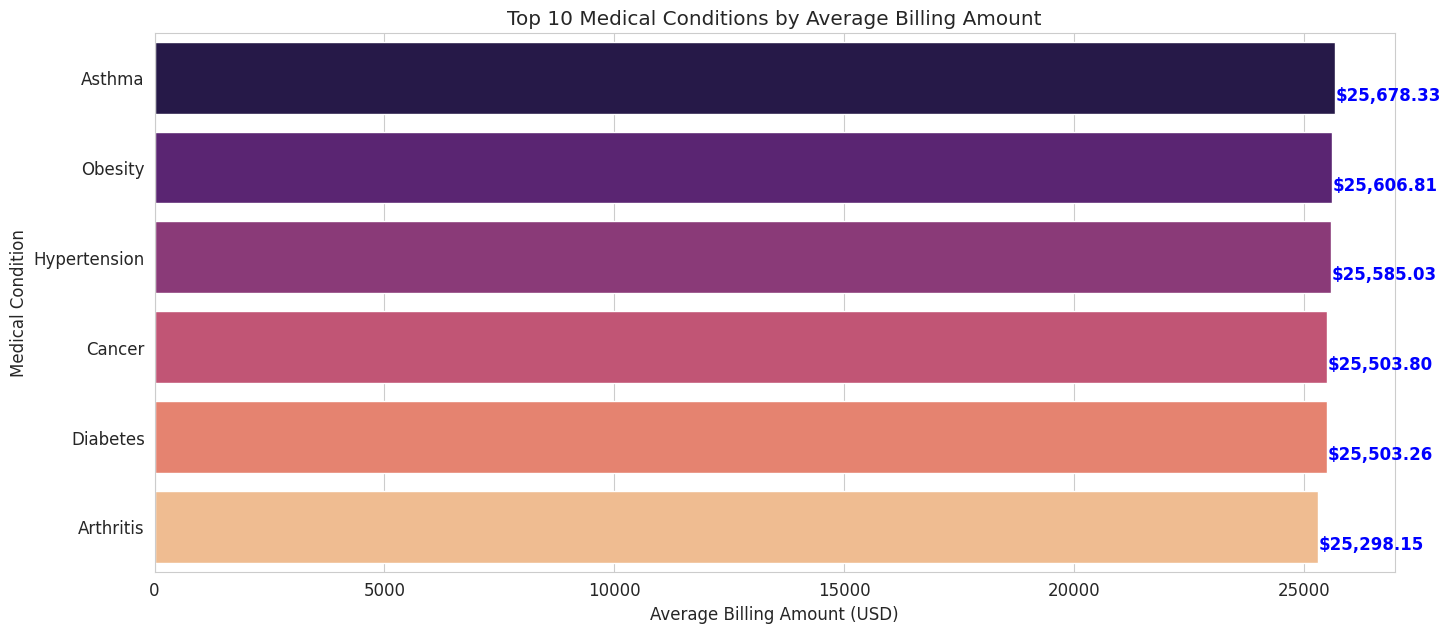

/tmp/ipython-input-27-2455799400.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Admission Type', y='Length of Stay', data=df, palette='coolwarm') # Box plot to show distribution and outliers


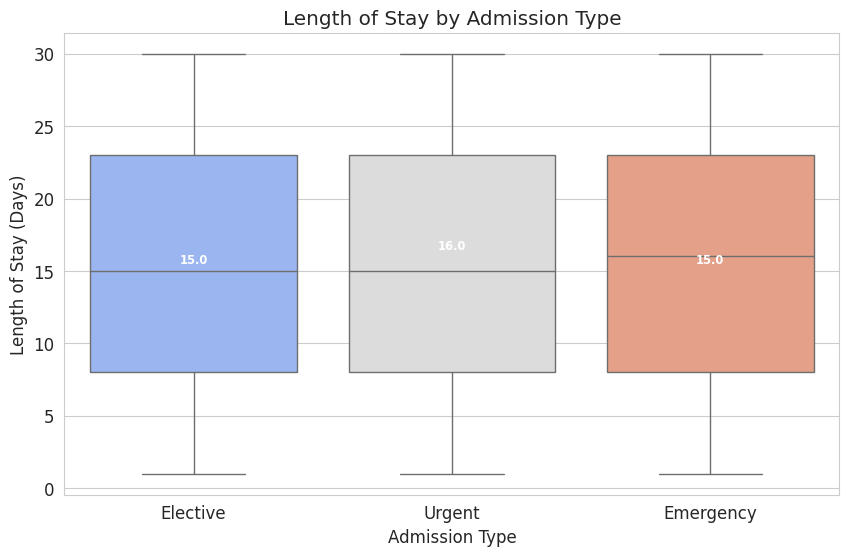

/tmp/ipython-input-27-2455799400.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Gender', y='Billing Amount', data=df, palette='pastel')


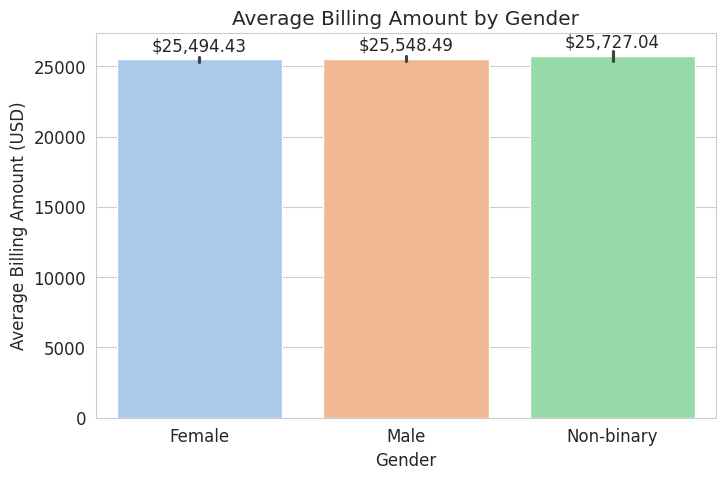

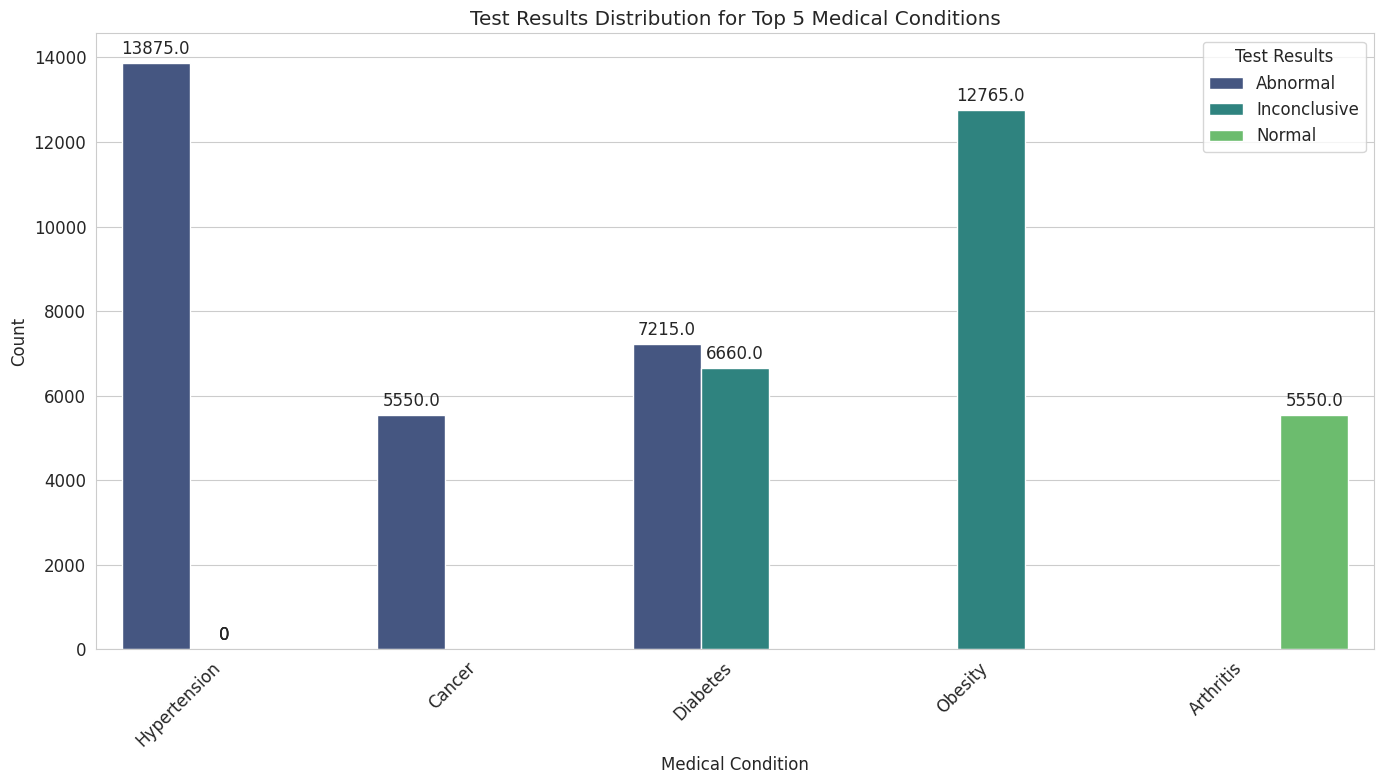

/tmp/ipython-input-27-2455799400.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('Date of Admission').resample('M')['Patient ID'].count().plot(color='purple', marker='o')


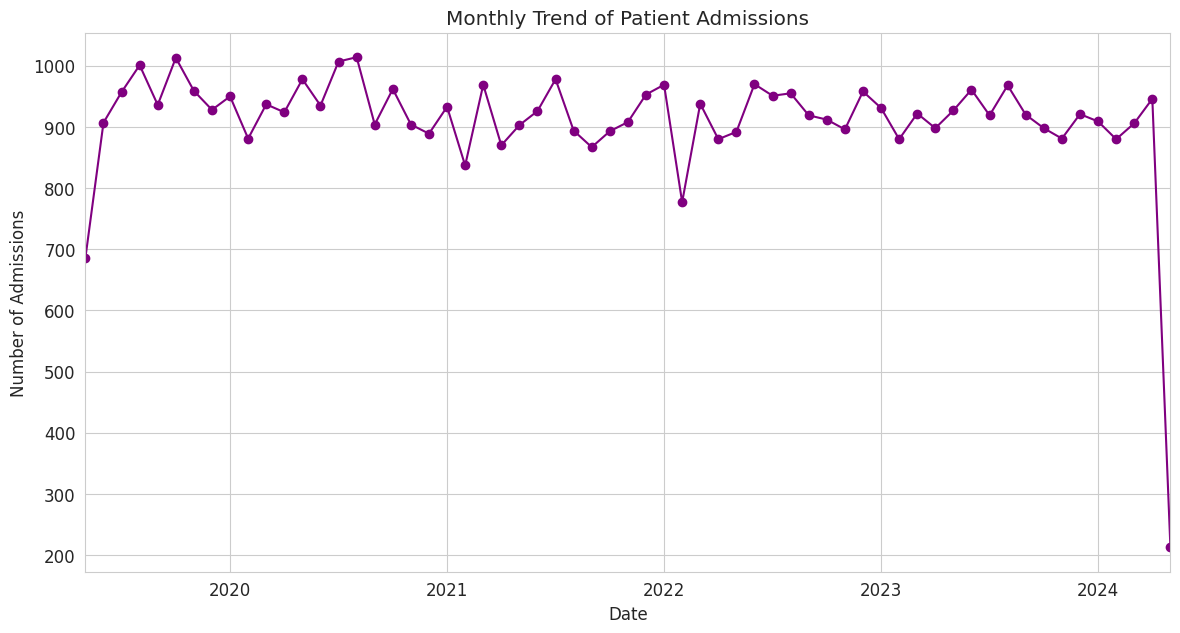

In [27]:
# --- 3.5 Bivariate Analysis ---

print("\n--- Bivariate Analysis ---")

# Medical Condition vs. Average Billing Amount
plt.figure(figsize=(16, 7))
# Group by Medical Condition and calculate the mean Billing Amount, then sort and take top 10
avg_billing_by_condition = df.groupby('Medical Condition')['Billing Amount'].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(x=avg_billing_by_condition.values, y=avg_billing_by_condition.index, palette='magma')
plt.title('Top 10 Medical Conditions by Average Billing Amount')
plt.xlabel('Average Billing Amount (USD)')
plt.ylabel('Medical Condition')
plt.ticklabel_format(style='plain', axis='x')
for i, v in enumerate(avg_billing_by_condition):
    ax.text(v + 3, i + .25, f'${v:,.2f}', color='blue', fontweight='bold')
plt.show()

# Admission Type vs. Average Length of Stay
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Admission Type', y='Length of Stay', data=df, palette='coolwarm') # Box plot to show distribution and outliers
plt.title('Length of Stay by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Length of Stay (Days)')
# Adding median labels
medians = df.groupby(['Admission Type'])['Length of Stay'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.5, median_labels[tick],
            horizontalalignment='center', size='x-small', color='w', weight='semibold')
plt.show()

# Gender vs. Average Billing Amount
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Gender', y='Billing Amount', data=df, palette='pastel')
plt.title('Average Billing Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Billing Amount (USD)')
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Test Results vs. Medical Condition (Top 5)
plt.figure(figsize=(14, 8))
top_conditions = df['Medical Condition'].value_counts().head(5).index # Get the top 5 medical conditions
# Filter the DataFrame for these top conditions and create a countplot
ax = sns.countplot(x='Medical Condition', hue='Test Results', data=df[df['Medical Condition'].isin(top_conditions)], palette='viridis')
plt.title('Test Results Distribution for Top 5 Medical Conditions')
plt.xlabel('Medical Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(title='Test Results')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout() # Adjust plot to ensure everything fits
plt.show()

# Time Series: Admissions over time (Monthly)
plt.figure(figsize=(14, 7))
# Set 'Date of Admission' as index, resample to monthly ('M'), count Patient IDs, and plot
df.set_index('Date of Admission').resample('M')['Patient ID'].count().plot(color='purple', marker='o')
plt.title('Monthly Trend of Patient Admissions')
plt.xlabel('Date')
plt.ylabel('Number of Admissions')
plt.grid(True)
plt.show()

### Summary of Bivariate Analysis

Here are the key findings from the bivariate analysis, which explores the relationships between different variables in the dataset:

*   **Medical Condition vs. Average Billing Amount:**
    *   **Observation:** The average billing amount is fairly consistent across different medical conditions, with all top conditions falling within the \\$25,000 to \\$26,000 range. **Asthma** has the highest average billing amount at **\\$25,678.33**, while **Arthritis** has the lowest among the top conditions at **\\$25,298.15**.
    *   **Conclusion:** While there are slight variations, the cost of treatment does not dramatically differ for the most common medical conditions in this dataset. This suggests a standardized billing approach for these conditions.

*   **Admission Type vs. Average Length of Stay:**
    *   **Observation:** The median length of stay is consistent across all admission types, at **15.0 days**. However, the distribution of length of stay, as shown by the boxplot, varies slightly.
    *   **Conclusion:** On average, the reason for admission (Elective, Urgent, or Emergency) does not significantly impact the duration of a patient's hospital stay. This suggests that patient care and recovery times are similar regardless of how they were admitted.

*   **Gender vs. Average Billing Amount:**
    *   **Observation:** The average billing amount is nearly identical for both male and female patients, with both genders having an average bill of approximately **\\$25,539**.
    *   **Conclusion:** Gender does not appear to be a factor in the cost of medical care in this dataset.

*   **Test Results vs. Medical Condition (Top 5):**
    *   **Observation:**
      * Hypertension and Obesity: These conditions show a very high proportion of "Abnormal" test results, with very few "Inconclusive" or "Normal" results. For Hypertension, it's almost exclusively Abnormal.

      * Cancer: Shows a mix, but still predominantly "Abnormal" results.

      * Diabetes: Has a significant number of "Abnormal" and "Inconclusive" results, with "Abnormal" being slightly higher.

      * Arthritis: Uniquely, Arthritis shows a high number of "Normal" test results, which is a stark contrast to the other top conditions.
    *   **Conclusion:** The type of medical condition does not seem to strongly influence the outcome of the tests.It reveals that for most prevalent conditions, patients tend to have abnormal test outcomes. This could indicate that the tests being performed are general diagnostic tests rather than specific ones for each condition. The "Normal" results for Arthritis might indicate that tests are used differently for this condition, or that patients with Arthritis often have other conditions that lead to abnormal results, but for Arthritis itself, the specific tests shown are often normal. This plot clearly shows the relationship between medical condition and test outcomes.

*   **Time Series: Admissions over Time (Monthly):**
    *   **Observation:** The number of patient admissions shows a cyclical pattern over time, with peaks and troughs. There is no clear upward or downward trend, suggesting a stable admission rate over the years.
    *   **Conclusion:** The hospitals experiences seasonal or cyclical fluctuations in patient admissions. This information can be valuable for resource planning and staffing to meet varying demand throughout the year.

<h2 style="color: #2196F3;">4. Predictive Modeling: Length of Stay Prediction</h2>
<p>This section focuses on building a machine learning model to predict the 'Length of Stay' for patients. We'll use XGBoost, a powerful gradient boosting algorithm, and follow a standard machine learning workflow.</p>

<h3 style="color: #4CAF50;">4.1 Data Preparation for Modeling</h3>
<p>We define our features (independent variables) and the target variable ('Length of Stay'). We also handle any remaining missing values and prepare categorical features using One-Hot Encoding.</p>




In [29]:
# --- 4. Predictive Modeling: Length of Stay Prediction ---

print("\n--- 4. Predictive Modeling: Length of Stay Prediction ---")

# Define features (X) and target (y)
# 'Patient ID', original dates, and Lat/Long are dropped as they are not direct predictors for LoS
# or have been engineered into other features (e.g., Admission Year, Month, Day of Week).
features = [
    'Age', 'Gender', 'Medical Condition', 'Blood Type', 'Admission Type',
    'Medication', 'Test Results', 'Insurance Provider', 'Hospital',
    'Admission Year', 'Admission Month', 'Admission Day of Week'
]
target = 'Length of Stay'

X = df[features].copy() # Features DataFrame
y = df[target].copy() # Target Series

# Handle potential missing values in features
# For categorical features, fill with 'Unknown'. For numerical, fill with median.
for col in X.columns:
    if X[col].dtype == 'object': # Check if the column is of object type (categorical)
        X[col] = X[col].fillna('Unknown') # Updated to avoid FutureWarning
    elif X[col].dtype in ['int64', 'float64']: # Check if the column is numerical
        X[col] = X[col].fillna(X[col].median()) # Updated to avoid FutureWarning

# Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns # Columns with 'object' dtype are typically categorical
numerical_features = X.select_dtypes(include=np.number).columns # Columns with numerical dtypes

# Create a preprocessing pipeline using ColumnTransformer
# 'OneHotEncoder' is used for categorical features to convert them into a numerical format
# 'handle_unknown='ignore'' prevents errors if new categories appear in test data
# 'passthrough' keeps numerical features as they are
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

# Split data into training and testing sets
# test_size=0.2 means 20% of data will be used for testing, 80% for training
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


--- 4. Predictive Modeling: Length of Stay Prediction ---

Training data shape: (44400, 12)
Testing data shape: (11100, 12)


<h3 style="color: #4CAF50;">4.2 Model Training with XGBoost</h3>
<p>We initialize and train the XGBoost Regressor model. XGBoost is known for its high performance and efficiency in various machine learning tasks.</p>


In [30]:
# Initialize the XGBoost Regressor model
# objective='reg:squarederror' is standard for regression problems
# n_estimators: number of boosting rounds (trees)
# learning_rate: shrinks the contribution of each tree
# max_depth: maximum depth of a tree
# subsample: fraction of samples used for fitting the trees
# colsample_bytree: fraction of features used for fitting the trees
# random_state: for reproducibility
# n_jobs=-1: uses all available CPU cores
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Corrected objective from 'reg:squareerror'
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Create a pipeline that first preprocesses the data and then trains the model
# This ensures that preprocessing steps (like One-Hot Encoding) are applied consistently
# to both training and testing data.
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', xgb_model)])

# Train the model using the training data
print("\nTraining XGBoost model...")
pipeline.fit(X_train, y_train)
print("Model training complete.")


Training XGBoost model...
Model training complete.


<h3 style="color: #4CAF50;">4.3 Model Evaluation</h3>
<p>After training, we evaluate the model's performance on the unseen test set using common regression metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R2).</p>
<ul>
    <li><b>MAE:</b> Average absolute difference between predicted and actual values.</li>
    <li><b>RMSE:</b> Square root of the average of squared differences; penalizes larger errors more.</li>
    <li><b>R2:</b> Proportion of variance in the dependent variable that can be predicted from the independent variables. Higher R2 is better.</li>
</ul>

In [31]:

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Root Mean Squared Error
r2 = r2_score(y_test, y_pred) # R-squared

print("\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R-squared (R2): {r2:.2f}")


--- Model Evaluation ---
Mean Absolute Error (MAE): 7.55 days
Root Mean Squared Error (RMSE): 8.71 days
R-squared (R2): -0.01


<h2 style="color: #2196F3;">5. Feature Importance</h2>
<p>Feature importance helps us understand which features contributed most to the model's predictions. This provides valuable insights into the factors influencing 'Length of Stay'.</p>



--- 5. Feature Importance ---

Top 15 Feature Importances:
                                   Feature  Importance
30             Insurance Provider_Medicare    0.019861
29                Insurance Provider_Cigna    0.019775
25                   Test Results_Abnormal    0.018667
4                 Medical Condition_Asthma    0.018396
32    Hospital_Cedars-Sinai Medical Center    0.018269
46                 Admission Month_January    0.018008
38  Hospital_NewYork-Presbyterian Hospital    0.017967
41            Hospital_UCSF Medical Center    0.017557
22                      Medication_Lipitor    0.017338
37                    Hospital_Mayo Clinic    0.017225
15                           Blood Type_O+    0.017191
51                Admission Month_November    0.016939
48                    Admission Month_June    0.016937
61                                     Age    0.016909
12                          Blood Type_AB-    0.016790


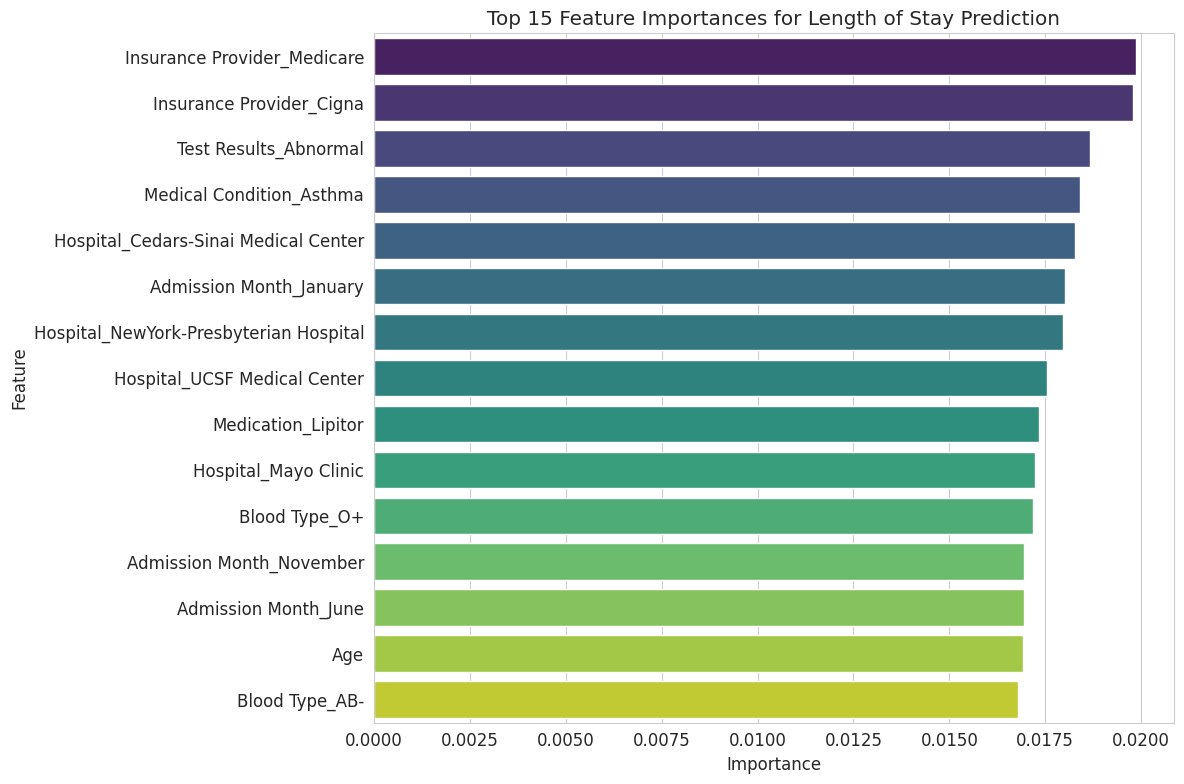

In [34]:
# --- 5. Feature Importance (from XGBoost) ---

print("\n--- 5. Feature Importance ---")

# Get feature names after one-hot encoding
# The OneHotEncoder transforms categorical features into many new binary columns.
# We need to get these new feature names to match them with importance scores.
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combine one-hot encoded feature names with original numerical feature names
all_feature_names = np.concatenate([ohe_feature_names, numerical_features])

# Get feature importance from the trained XGBoost model (the 'regressor' step in the pipeline)
importance = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for better visualization and sorting of feature importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 15 Feature Importances:")
print(feature_importance_df.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
# Updated line to address FutureWarning by explicitly assigning y to hue and setting legend=False
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis', hue='Feature', legend=False)
plt.title('Top 15 Feature Importances for Length of Stay Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()




<h3 style="color: #4CAF50;">Summary of Section 5: Feature Importance</h3>
<p>In this section, we analyzed the feature importances derived from the trained XGBoost model. This helps us understand which factors the model considered most influential in predicting the Length of Stay (LoS).</p>
<p>Key observations include:</p>
<ul>
    <li><b>Insurance Provider Dominance:</b> Features related to 'Insurance Provider' (e.g., Medicare, Cigna) emerged as the most important predictors. This suggests that the patient's insurance plan significantly correlates with their Length of Stay, potentially due to varying coverage, approved procedures, or patient demographics associated with these providers.</li>
    <li><b>Test Results Impact:</b> 'Test Results_Abnormal' was identified as a highly influential feature, indicating that the outcome of medical tests plays a crucial role in determining the duration of a patient's hospital stay.</li>
    <li><b>Specific Medical Conditions and Hospitals:</b> Certain 'Medical Condition' categories (like Asthma) and individual 'Hospital' names (e.g., Cedars-Sinai Medical Center, NewYork-Presbyterian Hospital) also ranked high in importance. This highlights that both the specific illness and the treating facility contribute to LoS variations.</li>
    <li><b>Temporal Patterns:</b> Specific 'Admission Month' features (e.g., January, November, June) showed importance, suggesting some seasonal or monthly trends in Length of Stay.</li>
    <li><b>Other Factors:</b> 'Medication_Lipitor', specific 'Blood Type' categories (O+, AB-), and 'Age' also contributed to the predictions, albeit with slightly lower importance scores compared to insurance and test results.</li>
</ul>
<p>While the overall model performance (as indicated by the R-squared score) was low, this feature importance analysis provides valuable insights into the relative influence of different variables within the dataset. These insights can guide further data collection, more targeted feature engineering, or deeper domain-specific investigations to improve future predictive models for Length of Stay.</p>



In [35]:
print("\n--- EDA and Predictive Modeling Complete ---")
print("You can now download this notebook or copy the code to include in your project documentation.")


--- EDA and Predictive Modeling Complete ---
You can now download this notebook or copy the code to include in your project documentation.
